# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3953.889187,0.9999,-131.886217,1768.96,1637.073783
OMUSDT,526.319895,1703.822672,0.4309,0.000000,1177.50,1177.500000
BTCUSDT,601.021649,867.447158,0.2194,3.537078,266.43,269.967078
JASMYUSDT,387.458505,555.211939,0.1404,0.000000,167.75,167.750000
SOLUSDT,281.200518,391.104391,0.0989,0.000000,109.90,109.900000
ETHUSDT,250.747339,261.865366,0.0662,0.000000,11.12,11.120000
TRXUSDT,76.868953,129.744306,0.0328,-10.723889,52.88,42.156111
BBUSDT,60.176053,43.503237,0.0110,-39.733101,-16.67,-56.403101
BNBUSDT,1.142121,1.190112,0.0003,-10.606040,0.05,-10.556040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [19]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [20]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [21]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [22]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-04    1729.714053
2024-12-05    1990.847138
2024-12-06    1981.149715
2024-12-07    1963.718646
2024-12-08    2075.031739
Name: Total, Length: 77, dtype: float64

In [23]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

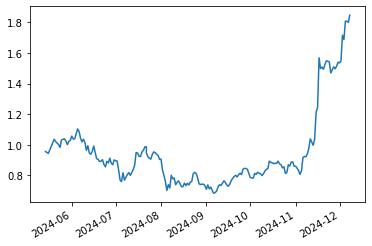

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3959
BNBUSDT,0.1685
PEPEUSDT,0.1581
TRXUSDT,0.0710
SUIUSDT,0.0708
XLMUSDT,0.0515
XRPUSDT,0.0456
JASMYUSDT,0.0385
DYDXUSDT,0.0000
WLDUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.381730
BTCUSDT,0.300000
PEPEUSDT,0.123624
TRXUSDT,0.060385
SUIUSDT,0.049578
XLMUSDT,0.036514
JASMYUSDT,0.030222
BNBUSDT,0.017948


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.370140
BTCUSDT,0.312755
TRXUSDT,0.210027
PEPEUSDT,0.107077


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1703.822672,0.430923,0.370140,0.060783
BTCUSDT,867.447158,0.219391,0.312755,-0.093364
JASMYUSDT,555.211939,0.140422,0.000000,0.000000
SOLUSDT,391.104391,0.098916,0.000000,0.000000
ETHUSDT,261.865366,0.066230,0.000000,0.000000
TRXUSDT,129.744306,0.032814,0.210027,-0.177213
BBUSDT,43.503237,0.011003,0.000000,0.000000
BNBUSDT,1.190112,0.000301,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.107077,-0.107077


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1703.822672,0.430923,0.381730,0.049193
BTCUSDT,867.447158,0.219391,0.300000,-0.080609
JASMYUSDT,555.211939,0.140422,0.030222,0.110200
SOLUSDT,391.104391,0.098916,0.000000,0.000000
ETHUSDT,261.865366,0.066230,0.000000,0.000000
TRXUSDT,129.744306,0.032814,0.060385,-0.027571
BBUSDT,43.503237,0.011003,0.000000,0.000000
BNBUSDT,1.190112,0.000301,0.017948,-0.017647
PEPEUSDT,0.000006,0.000000,0.123624,-0.123624
SUIUSDT,0.000000,0.000000,0.049578,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

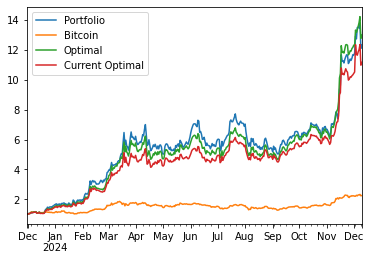

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

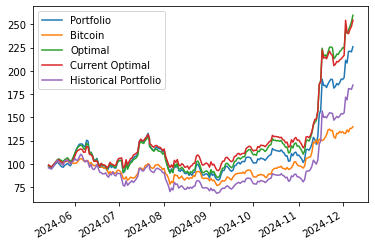

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-29,187.361562,134.971167,220.925665,211.745164,151.414174
2024-11-30,191.180417,133.506331,222.292505,212.948145,154.042164
2024-12-01,190.737188,134.578273,224.987691,214.937372,153.524639
2024-12-02,192.763205,132.703379,224.293402,216.828080,154.867822
2024-12-03,211.393426,132.715937,243.436544,254.480093,171.684779
2024-12-04,208.518312,136.453406,240.463777,241.328934,168.792541
2024-12-05,220.897120,134.162033,243.957387,239.961879,180.882889
2024-12-06,221.206994,137.975577,248.001216,244.683789,180.754476
2024-12-07,220.413967,138.101611,252.641874,247.817879,180.041463
2024-12-08,226.011384,139.857753,259.853561,254.671252,184.701345


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.661552
 dtype: float64,
 0.662403865589971)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.645265
 dtype: float64,
 0.6452649053177444)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.709770
Bitcoin            0.435027
Optimal            0.662404
Current Optimal    0.632207
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.45681249172252536

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.028524,0.017948,0.002212,0.006130,0.000169,0.005961
BTCUSDT,0.376779,0.300000,0.032208,0.131281,0.038818,0.092463
JASMYUSDT,0.080014,0.030222,0.005246,0.021309,0.002623,0.018686
OMUSDT,18.453661,0.381730,0.896378,0.649342,0.546275,0.103067
PEPEUSDT,0.854041,0.123624,0.046527,0.131159,0.055968,0.075191
SUIUSDT,0.115602,0.049578,0.007861,0.029573,0.005090,0.024484
TRXUSDT,0.054983,0.060385,0.005490,0.016995,0.003988,0.013008
XLMUSDT,0.049174,0.036514,0.004078,0.014210,0.001824,0.012386


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.868642,0.370140,0.560021,0.601953,0.474128,0.127825
BTCUSDT,0.141039,0.312755,0.205148,0.136633,0.050150,0.086483
TRXUSDT,0.130121,0.210027,0.153772,0.156290,0.104911,0.051379
PEPEUSDT,0.072229,0.107077,0.081059,0.105123,0.041559,0.063565


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.009121,0.43,0.647751,0.638664,0.509361,0.129304
BTCUSDT,0.099210,0.22,0.143677,0.089403,0.019753,0.069650
JASMYUSDT,0.066895,0.14,0.093124,0.145007,0.055599,0.089408
SOLUSDT,0.024496,0.10,0.056036,0.071036,0.009978,0.061058
ETHUSDT,0.009151,0.07,0.035626,0.033373,0.003530,0.029843
TRXUSDT,0.018586,0.03,0.021869,0.011880,0.001704,0.010176
BBUSDT,-0.005741,0.01,0.001917,0.010637,0.000391,0.010245


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05265594950935473, -0.07785701672503734)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048151061812145776, -0.07441724519539683)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.016731
BTCUSDT     -0.011273
JASMYUSDT   -0.011370
SOLUSDT     -0.007623
ETHUSDT      0.001101
TRXUSDT     -0.001870
BBUSDT      -0.000124
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047891
Name: 2024-11-25 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.040710
BTCUSDT     -0.007590
JASMYUSDT   -0.012470
SOLUSDT     -0.006799
ETHUSDT     -0.002833
TRXUSDT     -0.000930
BBUSDT      -0.000875
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072207
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0686356648025198, -0.08797194556650464)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06685979362571057, -0.08569576971902236)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06117270673935124, -0.0786846879291324)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06195873055540866, -0.07887537847751552)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.040076
BTCUSDT     -0.005097
JASMYUSDT   -0.009000
SOLUSDT     -0.004223
ETHUSDT     -0.001747
TRXUSDT     -0.001074
BBUSDT      -0.000560
Portfolio   -0.061777
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061688170438826934, -0.080237405813327)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06156240998121083, -0.0777449209580416)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039600
BTCUSDT     -0.005350
JASMYUSDT   -0.008437
SOLUSDT     -0.004721
ETHUSDT     -0.002192
TRXUSDT     -0.000987
BBUSDT      -0.000836
Portfolio   -0.062123
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06000458310051064, -0.07811343205579954)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06323673558003949, -0.08114848108883006)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039606
BTCUSDT     -0.005713
JASMYUSDT   -0.009808
SOLUSDT     -0.004775
ETHUSDT     -0.002130
TRXUSDT     -0.000528
BBUSDT      -0.000862
Portfolio   -0.063422
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11635448854087085, -0.16328125864991774)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10667283212537876, -0.15084516590623157)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.091637
BTCUSDT     -0.003178
JASMYUSDT   -0.011608
SOLUSDT     -0.001894
ETHUSDT     -0.000252
TRXUSDT      0.000487
BBUSDT       0.000124
Portfolio   -0.107957
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07201775781815388, -0.09046714763265454)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06915477466740161, -0.086647743150181)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.045124
BTCUSDT     -0.005557
JASMYUSDT   -0.009616
SOLUSDT     -0.004729
ETHUSDT     -0.002062
TRXUSDT     -0.000714
BBUSDT      -0.000796
Portfolio   -0.068598
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056897,-0.094855,-0.083089,-0.026922
2024-01-15,-0.056897,-0.094855,-0.082392,0.016583
2024-01-16,-0.056897,-0.094745,-0.077192,0.045776
2024-01-17,-0.056897,-0.096517,-0.079292,-0.029029
2024-01-18,-0.056897,-0.099134,-0.085320,-0.039224
...,...,...,...,...
2024-12-06,-0.047695,-0.118400,-0.094142,0.016576
2024-12-07,-0.047695,-0.118232,-0.092133,0.018712
2024-12-08,-0.047695,-0.117243,-0.087342,0.028545
2024-12-09,-0.087739,-0.129283,-0.108944,-0.102405


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034152,-0.084996,-0.079467,-0.017632
2024-05-29,-0.034152,-0.082329,-0.076309,-0.008918
2024-05-30,-0.034152,-0.072422,-0.069296,0.039622
2024-05-31,-0.034152,-0.073307,-0.065164,0.038617
2024-06-01,-0.034152,-0.076621,-0.067488,0.052272
...,...,...,...,...
2024-12-06,-0.043090,-0.075336,-0.061503,0.001403
2024-12-07,-0.043090,-0.075887,-0.065581,-0.003585
2024-12-08,-0.043090,-0.076390,-0.062736,0.025395
2024-12-09,-0.113315,-0.111785,-0.107009,-0.123966


<AxesSubplot:>

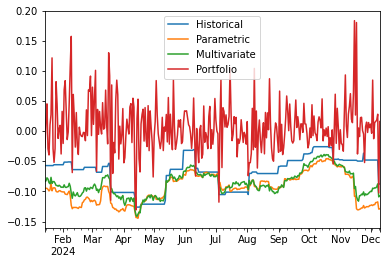

In [79]:
var_data.plot()

<AxesSubplot:>

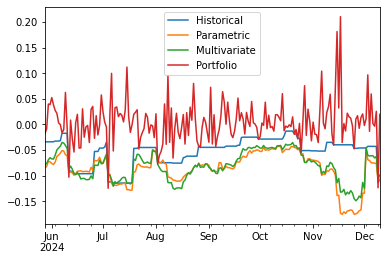

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024096,0.006024,0.012048
Kupiec Stat,5.753015,21.400625,14.311922
P-value,0.01646,0.000004,0.000155


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.06599,0.020305,0.015228
Kupiec Stat,0.967744,4.671569,6.814562
P-value,0.325243,0.030666,0.009042


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77219325, 0.07470567, 0.05939204, 0.05276269, 0.04094635])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014802
ADAUSDT     0.015331
ALGOUSDT    0.017306
APTUSDT     0.016024
ARBUSDT     0.016817
              ...   
WBTCUSDT    0.009335
WLDUSDT     0.022039
XLMUSDT     0.012340
XRPUSDT     0.010803
XTZUSDT     0.016167
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

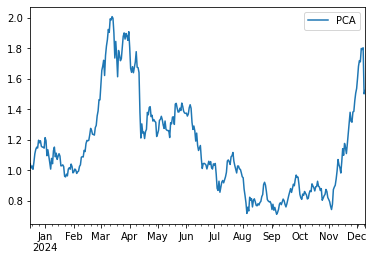

In [85]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

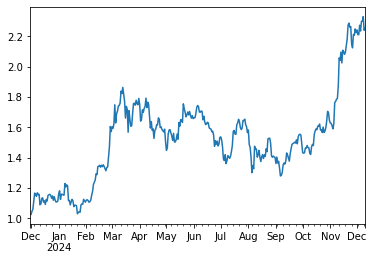

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.412887
ETHUSDT      0.425145
WBETHUSDT    0.425152
EGLDUSDT     0.425608
               ...   
FLOKIUSDT    1.120935
BONKUSDT     1.125960
WLDUSDT      1.132252
PEPEUSDT     1.177319
OMUSDT       1.521749
Length: 64, dtype: float64

<AxesSubplot:>

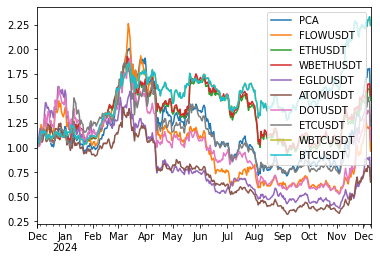

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

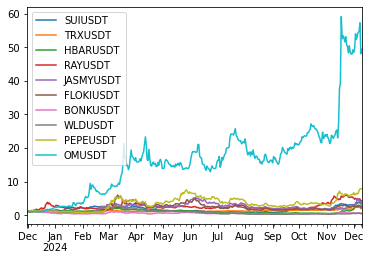

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53185125, 0.15327091, 0.13554715, 0.10236111, 0.07696958])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.105642
BTCUSDT      0.061470
JASMYUSDT    0.165522
SOLUSDT      0.101707
ETHUSDT      0.082563
TRXUSDT      0.049354
BBUSDT       0.212321
BNBUSDT      0.067313
PEPEUSDT     0.154109
Name: PC1, dtype: float64

<AxesSubplot:>

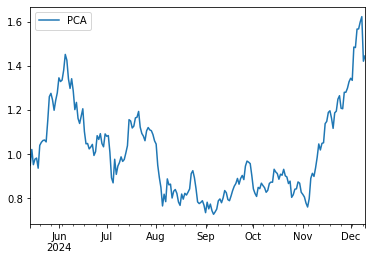

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

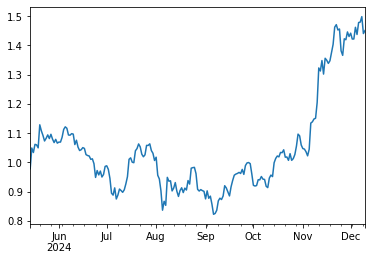

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.382584
ETHUSDT      0.403579
BNBUSDT      0.408114
BTCUSDT      0.421836
JASMYUSDT    0.640315
PEPEUSDT     0.703094
BBUSDT       0.714687
OMUSDT       0.859236
TRXUSDT      0.874334
dtype: float64

<AxesSubplot:>

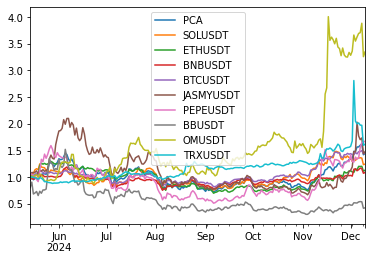

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.896286
BBUSDT       1.556955
JASMYUSDT    1.231724
SOLUSDT      1.145714
BTCUSDT      1.000000
ETHUSDT      0.955481
OMUSDT       0.893555
BNBUSDT      0.660022
TRXUSDT      0.263914
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.034315
ETHUSDT      1.743432
PEPEUSDT     1.498762
BNBUSDT      1.067295
SOLUSDT      1.054180
BTCUSDT      1.000000
OMUSDT       0.560720
TRXUSDT      0.046617
JASMYUSDT   -0.354410
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [98]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [99]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.700633
BBUSDT,0.441679
ETHUSDT,0.222382
JASMYUSDT,0.124829
OMUSDT,0.086203
TRXUSDT,0.016882
PEPEUSDT,-0.008433
BNBUSDT,-0.022608
SOLUSDT,-0.417975


### Regression to PCA

In [100]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.2502443688788954

In [101]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.245194
BNBUSDT      1.099570
PCA          1.000000
ETHUSDT      0.954852
SOLUSDT      0.790013
JASMYUSDT    0.404432
PEPEUSDT     0.364083
BBUSDT       0.345964
OMUSDT       0.237681
TRXUSDT      0.181099
dtype: float64

In [102]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.757649
SOLUSDT      1.074154
PCA          1.000000
ETHUSDT      0.896983
BNBUSDT      0.772246
OMUSDT       0.713749
BBUSDT       0.638706
JASMYUSDT    0.156695
TRXUSDT      0.109202
PEPEUSDT     0.027411
dtype: float64

### Correlation Matrix

In [103]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.303085,0.168033,0.361477,0.237721,0.152430,0.291775,0.217676,0.168661
BTCUSDT,0.303085,1.000000,0.477353,0.705742,0.791042,0.165738,0.560030,0.598283,0.650774
JASMYUSDT,0.168033,0.477353,1.000000,0.462704,0.469248,0.255904,0.557971,0.448275,0.365997
SOLUSDT,0.361477,0.705742,0.462704,1.000000,0.656962,0.194687,0.560451,0.515456,0.537099
ETHUSDT,0.237721,0.791042,0.469248,0.656962,1.000000,0.148772,0.612453,0.590533,0.634826
TRXUSDT,0.152430,0.165738,0.255904,0.194687,0.148772,1.000000,0.171332,0.317293,0.093259
BBUSDT,0.291775,0.560030,0.557971,0.560451,0.612453,0.171332,1.000000,0.593060,0.460691
BNBUSDT,0.217676,0.598283,0.448275,0.515456,0.590533,0.317293,0.593060,1.000000,0.414684
PEPEUSDT,0.168661,0.650774,0.365997,0.537099,0.634826,0.093259,0.460691,0.414684,1.000000


In [104]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.207759,0.521442,0.563598,0.202084,0.625182,0.778735,0.532636,-0.209919
BTCUSDT,0.207759,1.000000,-0.055535,0.631945,0.881105,0.004806,0.572114,0.502134,0.528449
JASMYUSDT,0.521442,-0.055535,1.000000,0.588920,0.061524,0.491315,0.433388,0.351711,-0.264568
SOLUSDT,0.563598,0.631945,0.588920,1.000000,0.564821,0.474995,0.755148,0.666838,0.293696
ETHUSDT,0.202084,0.881105,0.061524,0.564821,1.000000,-0.050833,0.644534,0.451808,0.385241
TRXUSDT,0.625182,0.004806,0.491315,0.474995,-0.050833,1.000000,0.524954,0.785118,-0.223184
BBUSDT,0.778735,0.572114,0.433388,0.755148,0.644534,0.524954,1.000000,0.715707,0.018524
BNBUSDT,0.532636,0.502134,0.351711,0.666838,0.451808,0.785118,0.715707,1.000000,0.227955
PEPEUSDT,-0.209919,0.528449,-0.264568,0.293696,0.385241,-0.223184,0.018524,0.227955,1.000000


## Sliding window optimization

In [105]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [106]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-06-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-07-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948311,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-08-02,0.614341,0.053671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.325820,0.0
2024-09-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.982006,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-31,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664610,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-11-30,0.000000,0.044675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0347,0.182972,0.0
2024-12-10,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0


In [107]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

PEPEUSDT     0.595312
HBARUSDT     0.141005
CRVUSDT      0.134429
JASMYUSDT    0.129254
SEIUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
ICPUSDT      0.000000
IMXUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-10 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

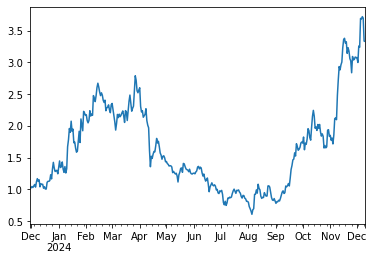

In [108]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()